In [10]:
import yfinance as yf

# Define available companies and their stock tickers
companies = {
    "Apple": "AAPL",
    "Google": "GOOGL",
    "Microsoft": "MSFT",
    "Amazon": "AMZN",
    "Tesla": "TSLA"
}

# Display company choices
print("Select a company to predict stock prices:")
for idx, company in enumerate(companies.keys(), 1):
    print(f"{idx}. {company}")

# Get user selection
choice = int(input("Enter the number of the company: "))
company_name = list(companies.keys())[choice - 1]
stock_ticker = companies[company_name]

print(f"\n📊 You selected: {company_name} ({stock_ticker})\n")


Select a company to predict stock prices:
1. Apple
2. Google
3. Microsoft
4. Amazon
5. Tesla

📊 You selected: Apple (AAPL)



In [11]:
# Fetch data from Yahoo Finance
stock_data = yf.download(stock_ticker, period="1y", interval="1d")  # 1 year of daily data

# Display last 5 days for verification
print(stock_data.tail())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-03-17  214.000000  215.220001  209.970001  213.309998  48073400
2025-03-18  212.690002  215.149994  211.490005  214.160004  42432400
2025-03-19  215.240005  218.759995  213.750000  214.220001  54385400
2025-03-20  214.100006  217.490005  212.220001  213.990005  48862900
2025-03-21  218.270004  218.839996  211.279999  211.559998  93954500


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Select only the 'Close' prices
stock_prices = stock_data[['Close']].dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_prices)

# Convert to training format (sequence data for LSTM)
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # 60 past days to predict 1 future day
X, y = create_sequences(scaled_data, seq_length)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.3214 - val_loss: 0.0289
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0424 - val_loss: 0.0541
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0190 - val_loss: 0.0140
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0298 - val_loss: 0.0101
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0136 - val_loss: 0.0343
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0159 - val_loss: 0.0276
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0100 - val_loss: 0.0132
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0099 - val_loss: 0.0182
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0102 - val_loss: 0.0186
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0093 - val_loss: 0.0146
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0081 - val_loss: 0.0149


In [14]:
def predict_next_7_days(model, data, scaler, seq_length):
    predictions = []
    last_sequence = data[-seq_length:]  # Last available sequence

    for _ in range(7):  # Predict for 7 days
        pred = model.predict(last_sequence.reshape(1, seq_length, 1))
        predictions.append(pred[0, 0])
        
        # Update sequence with new prediction
        last_sequence = np.append(last_sequence[1:], pred, axis=0).reshape(seq_length, 1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Get Predictions
future_prices = predict_next_7_days(model, scaled_data, scaler, seq_length)

# Display Predictions
print("\n📅 Stock Price Predictions for Next 7 Days:")
for i, price in enumerate(future_prices, 1):
    print(f"Day {i}: ${price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

📅 Stock Price Predictions for Next 7 Days:
Day 1: $221.80
Day 2: $221.44
Day 3: $221.34
Day 4: $221.40
Day 5: $221.55
Day 6: $221.76
Day 7: $222.00


In [16]:
selected_day = int(input("\nEnter the day (1-7) you want to check price for: "))
predicted_price = future_prices[selected_day - 1][0]
today_price = float(stock_data.iloc[-1]['Close'])

profit_loss = predicted_price - today_price
percent_change = (profit_loss / today_price) * 100

# Display Results
print("\n📊 Investment Summary")
print(f"📅 Selected Date: Day {selected_day}")
print(f"💰 Predicted Price: ${predicted_price:.2f}")
print(f"📈 Today's Price: ${today_price:.2f}")
print(f"📊 Change: {profit_loss:.2f} ({percent_change:.2f}%)")

# Profit/Loss Decision
if profit_loss > 0:
    print("✅ Suggested: **BUY** (Price Expected to Increase)")
else:
    print("❌ Suggested: **SELL** (Price Expected to Decrease)")



📊 Investment Summary
📅 Selected Date: Day 1
💰 Predicted Price: $221.80
📈 Today's Price: $218.27
📊 Change: 3.53 (1.62%)
✅ Suggested: **BUY** (Price Expected to Increase)


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


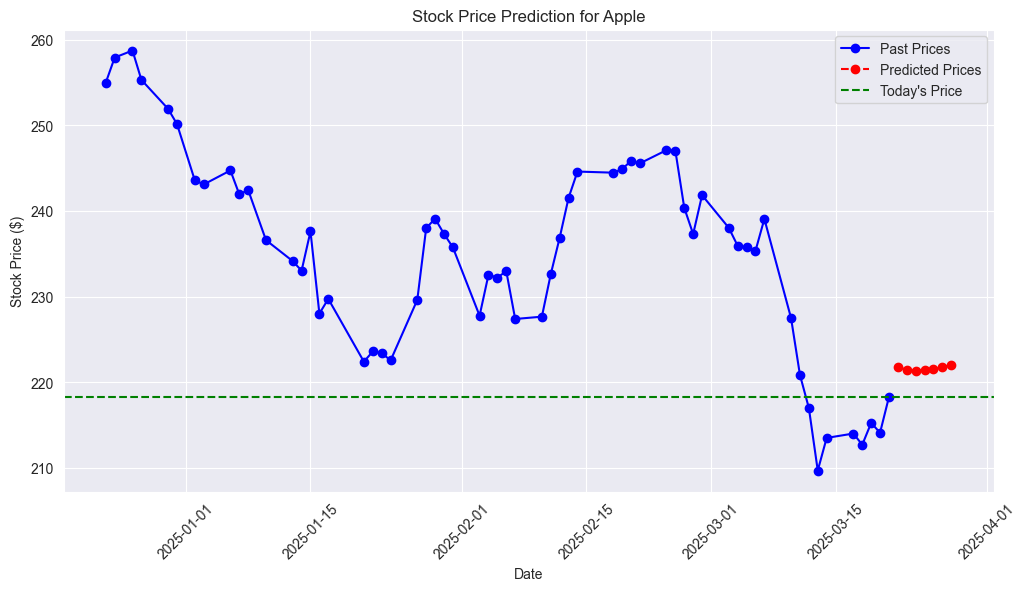

In [19]:
# Generate dates for visualization
import datetime

# Get past 60 days data for plotting
historical_prices = stock_data['Close'].iloc[-60:]  # Last 60 days
historical_dates = historical_prices.index

# Generate future dates (next 7 days)
future_dates = [historical_dates[-1] + datetime.timedelta(days=i) for i in range(1, 8)]

# Plot the data
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot historical stock prices
plt.plot(historical_dates, historical_prices, label="Past Prices", marker='o', color='blue')

# Plot predicted stock prices
plt.plot(future_dates, future_prices, label="Predicted Prices", marker='o', linestyle='dashed', color='red')

# Highlight today's price
plt.axhline(y=today_price, color='green', linestyle='--', label="Today's Price")

# Labels & Title
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.title(f"Stock Price Prediction for {company_name}")
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()
